In [4]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from statsmodels.stats.multitest import multipletests
import numpy as np
import statsmodels.api as sm


In [5]:
data = pd.read_excel('./luad2.xlsx', index_col=0)

In [25]:

# Convert RECIST labels into binary outcome: 1 for CR/PR, 0 for SD/PD
data['binary_label'] = data['Label'].apply(lambda x: 1 if x in ['CR', 'PR'] else 0)

# Store results
results = []

# Iterate over each immune cell type column to perform logistic regression
for cell_type in data.columns[1:-2]:  # exclude the first and last two columns
    X = sm.add_constant(data[cell_type])  # adding a constant for intercept
    y = data['binary_label']
    
    # Fit logistic regression model using statsmodels
    model = sm.Logit(
        y, X)

    model = model.fit(method='lbfgs',maxiter=99999,disp=0)
    
    # Get the p-value and coefficient for the immune cell type
    p_value = model.pvalues[1]
    coef = model.params[1]

    # Store the results
    results.append({
        'cell_type': cell_type,
        'coef': coef,
        'p_value': p_value
    })

# Convert results to a DataFrame
results_df = pd.DataFrame(results)

# Adjust p-values for multiple testing to get q-values
results_df['q_value'] = multipletests(results_df['p_value'], method='fdr_bh')[1]
#results_df['q_value'] = results_df['p_value']

results_df['signed_log10_q_value'] = np.sign(results_df['coef']) * -np.log10(results_df['q_value'])



# Sort the results by the absolute signed log10 q-value
results_df_sorted = results_df.sort_values(by='signed_log10_q_value', key=abs, ascending=False)
results_df_sorted.reset_index(drop=True, inplace=True)
results_df_sorted

,cell_type,coef,p_value,q_value,signed_log10_q_value
0,Cytotoxic cells,0.382441,0.100007,0.190868,0.719267
1,DC,-0.372552,0.125374,0.190868,-0.719267
2,Exhausted CD8,0.505044,0.033039,0.190868,0.719267
3,Exhausted/HS CD8,0.376337,0.133607,0.190868,0.719267
4,Lymphocytes,0.411538,0.091551,0.190868,0.719267
5,Lymphocytes exhausted/cell cycle,0.386059,0.130418,0.190868,0.719267
6,Treg,0.455104,0.068958,0.190868,0.719267
7,Macrophages/Monocytes,-0.344606,0.153946,0.192433,-0.715722
8,Memory T cells,0.182674,0.447907,0.497674,0.303055
9,Plasma,0.048180,0.824968,0.824968,0.083563


In [26]:
results_df['p_value']

0    0.100007
1    0.125374
2    0.033039
3    0.133607
4    0.091551
5    0.130418
6    0.153946
7    0.447907
8    0.824968
9    0.068958
Name: p_value, dtype: float64

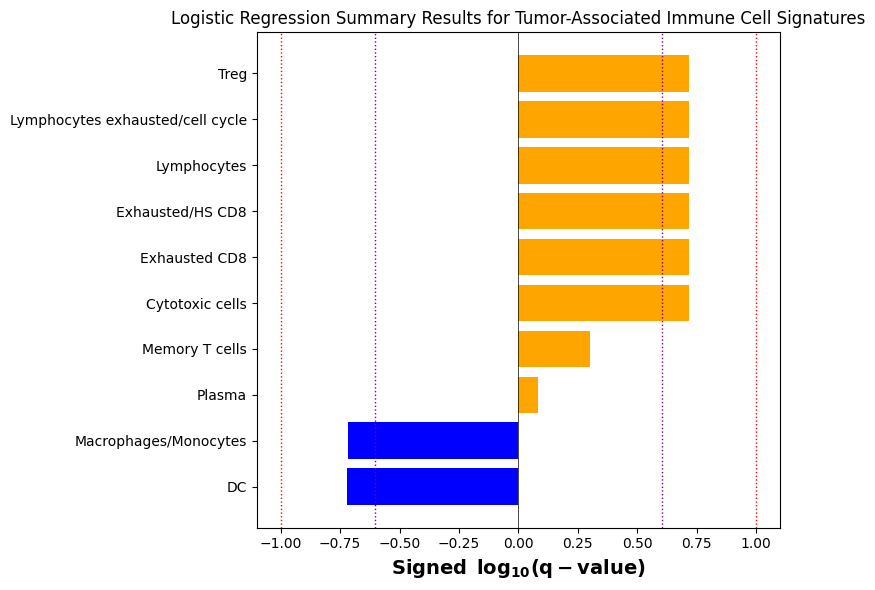

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


# Sorting values by the 'signed_log10_q_value' column for better visualization
df = results_df_sorted.sort_values(by='signed_log10_q_value')

# Plotting
plt.figure(figsize=(8, 6))
bar_colors = df['signed_log10_q_value'].apply(lambda x: 'orange' if x > 0 else 'blue')
bars = plt.barh(df['cell_type'], df['signed_log10_q_value'], color=bar_colors)

# Add lines for FDR thresholds
plt.axvline(x=0, color='black', linewidth=0.5)
plt.axvline(x=np.log10(0.25), color='purple', linestyle='dotted', linewidth=1)
plt.axvline(x=-np.log10(0.25), color='purple', linestyle='dotted', linewidth=1)
plt.axvline(x=np.log10(0.1), color='red', linestyle='dotted', linewidth=1)
plt.axvline(x=-np.log10(0.1), color='red', linestyle='dotted', linewidth=1)

plt.xlabel('Signed log10(q value)')
plt.title('Logistic Regression Summary Results for Tumor-Associated Immune Cell Signatures')


plt.xlabel('$\mathregular{Signed\hspace{0.5}log_{10}(q-value)}$',weight='bold',fontsize=14)


# Show the plot
plt.tight_layout()
plt.show()
